<a href="https://colab.research.google.com/github/Joocheol/Financial-Engineering/blob/master/Two_versions_of_delta_hedging_version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$\Delta$

$S_0$

$\max(S_T - K, 0)$

$\Delta_0 S_0$





In [140]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

In [141]:
r = 0.00
sig = 0.2
T = 30/365

M = 1000
N = 30

dt = T/N
rdt = r*dt
sigsdt = sig * np.sqrt(dt)

In [142]:
np.random.seed(1234)
S0 = 100

S = np.empty([M,N+1])
rv = np.random.normal(r*dt,sigsdt,[M,N])

In [143]:
for i in range(M):
    S[i,0] = S0
    for j in range(N):
        S[i,j+1] = S[i,j] * (1+rv[i,j])

$(\Delta_0 - 0) S_0 + (\Delta_1 - \Delta_0) S_1 + (\Delta_2 - \Delta_1) S_{2} + \cdots + (\Delta_{T-1} - \Delta_{T-2}) S_{T-1}+ (\Delta_{T} - \Delta_{T-1}) S_T$

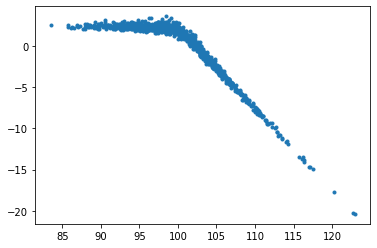

In [144]:
a = []

K = 100

for i in range(M):
    cost = 0
    hedge = 0
    for j in range(N):
        d1 = (np.log(S[i,j]/K)+(r+0.5*sig**2)*(T-j*dt))/(sig*np.sqrt(T-j*dt))
        delta = norm.cdf(d1)
        cost = cost + (delta-hedge) * S[i,j]
        hedge = delta
    
    #cost = cost - hedge * S[i,N] + np.maximum(S[i,N]-K, 0) - 2.2871506280449694
    cost = cost - hedge * S[i,N]
        

    a.append(cost)

plt.plot(S[:,-1], a, marker=".", linestyle='none')
plt.show()

(array([  2.,   1.,   8.,   8.,  18.,  47.,  82., 108., 162., 564.]),
 array([-20.3825907 , -17.98656762, -15.59054453, -13.19452145,
        -10.79849837,  -8.40247529,  -6.00645221,  -3.61042912,
         -1.21440604,   1.18161704,   3.57764012]),
 <a list of 10 Patch objects>)

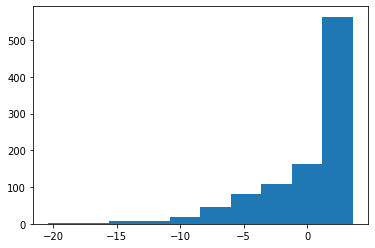

In [145]:
plt.hist(a)

$(\Delta_0 - 0) S_0 + (\Delta_1 - \Delta_0) S_1 + (\Delta_2 - \Delta_1) S_{2} + \cdots + (\Delta_{T-1} - \Delta_{T-2}) S_{T-1}+ (\Delta_{T} - \Delta_{T-1}) S_T$

$\Delta_0 (S_0-S_1) + \Delta_1 (S_1-S_2) + \Delta_2 (S_2-S_3) + \cdots + \Delta_{T-1} (S_{T-1}-S_T) + \Delta_T S_T$

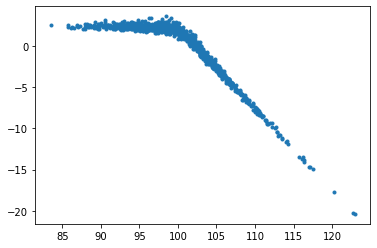

In [146]:
a = []

K = 100

for i in range(M):
    cost = 0
    price = S[i,0]
    for j in range(N):
        d1 = (np.log(price/K)+(r+0.5*sig**2)*(T-j*dt))/(sig*np.sqrt(T-j*dt))
        delta = norm.cdf(d1)
        cost = cost + delta*(price-S[i,j+1])
        price = S[i,j+1]
    
    #cost = cost + np.maximum(S[i,N]-K, 0) - 2.2871506280449694
        

    a.append(cost)

plt.plot(S[:,-1], a, marker=".", linestyle='none')
plt.show()

In [147]:
def bscall(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    
def bsput(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return K*np.exp(-r*T)*norm.cdf(-d2)-S*norm.cdf(-d1)

In [148]:
bscall(S0,K,T,r,sig)

2.2871506280449694

In [149]:
import tensorflow as tf

In [172]:
K = 100

my_input = []

premium = tf.keras.layers.Input(shape=(1,), name="premium")
my_input = my_input + [premium]

hedge_cost = tf.keras.layers.Input(shape=(1,), name='hedge_cost')
my_input = my_input + [hedge_cost]

price = tf.keras.layers.Input(shape=(1,), name="price")
my_input = my_input + [price]

# premium = tf.keras.layers.Dense(1, activation='linear', trainable=True,
#                 kernel_initializer=tf.keras.initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
#                 bias_initializer=tf.keras.initializers.RandomNormal(0,1))(premium)

for j in range(N):
    
    delta = tf.keras.layers.Dense(32, activation='tanh')(price)
    delta = tf.keras.layers.BatchNormalization()(delta)
    #delta = tf.keras.layers.Dropout(0.5)(delta)
    delta = tf.keras.layers.Dense(32, activation='relu')(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='tanh')(delta)
    delta = tf.keras.layers.Dense(1)(delta)

    new_price = tf.keras.layers.Input(shape=(1,), name='S'+str(j))
    my_input = my_input + [new_price]


    price_inc = tf.keras.layers.Subtract(name='price_inc_'+str(j))([price, new_price])
    cost = tf.keras.layers.Multiply(name="multiply_"+str(j))([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_'+str(j))([hedge_cost, cost])
    price = new_price

payoff = tf.keras.layers.Lambda(lambda x : 0.5*(tf.abs(x-K)+x-K))(price)
cum_cost = tf.keras.layers.Add(name="final")([hedge_cost, payoff])
cum_cost = tf.keras.layers.Subtract(name="final_")([cum_cost, premium])

model = tf.keras.Model(inputs=my_input, outputs=cum_cost)

#tf.keras.utils.plot_model(model)

In [173]:

p = 2.2871506280449694 * np.ones([M,1])
c = np.zeros([M,1])
SS = [S[:,i].reshape(M,1) for i in range(N+1)]
x = [p]+[c]+[SS]
y = 2.2871506280449694 * np.zeros([M,1])

In [174]:
x

[array([[2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2.28715063],
        [2

In [180]:

model.compile(loss='mae', optimizer='adam')

In [181]:
model.fit(x,y, batch_size=128, epochs=100,  verbose=True)

Epoch 1/100
8/8 [==============================] - 21s 76ms/step - loss: 0.5217
Epoch 2/100
8/8 [==============================] - 1s 77ms/step - loss: 0.4874
Epoch 3/100
8/8 [==============================] - 1s 77ms/step - loss: 0.4483
Epoch 4/100
8/8 [==============================] - 1s 75ms/step - loss: 0.4410
Epoch 5/100
8/8 [==============================] - 1s 76ms/step - loss: 0.4401
Epoch 6/100
8/8 [==============================] - 1s 77ms/step - loss: 0.4492
Epoch 7/100
8/8 [==============================] - 1s 83ms/step - loss: 0.4433
Epoch 8/100
8/8 [==============================] - 1s 81ms/step - loss: 0.4094
Epoch 9/100
8/8 [==============================] - 1s 76ms/step - loss: 0.3914
Epoch 10/100
8/8 [==============================] - 1s 74ms/step - loss: 0.3619
Epoch 11/100
8/8 [==============================] - 1s 76ms/step - loss: 0.3921
Epoch 12/100
8/8 [==============================] - 1s 77ms/step - loss: 0.3846
Epoch 13/100
8/8 [==============================

In [182]:
model.predict(x)

array([[ 9.72937346e-01],
       [ 3.71168971e+00],
       [-2.99335194e+00],
       [-2.23550797e-01],
       [ 4.66290951e+00],
       [ 4.98334599e+00],
       [-7.32649899e+00],
       [ 6.40013981e+00],
       [-3.76803041e-01],
       [-1.74060678e+00],
       [-1.79931664e+00],
       [ 7.24798918e-01],
       [ 5.07222462e+00],
       [ 3.64471126e+00],
       [-4.54861450e+00],
       [-5.27494574e+00],
       [-4.89431810e+00],
       [-6.36316419e-01],
       [-3.44092679e+00],
       [ 1.45113492e+00],
       [ 1.29568577e-02],
       [ 3.03556848e+00],
       [ 3.22532153e+00],
       [ 4.24376774e+00],
       [-1.59745812e+00],
       [-1.01840181e+01],
       [ 4.28798485e+00],
       [ 1.98183513e+00],
       [-3.17465162e+00],
       [-3.12125492e+00],
       [-1.57045054e+00],
       [ 4.88805389e+00],
       [ 2.22561002e+00],
       [-1.35944760e+00],
       [ 4.72924042e+00],
       [ 5.69878960e+00],
       [ 2.52805781e+00],
       [ 7.03824759e-01],
       [ 5.7

(array([  1.,   4.,   5.,  11.,  13.,  45.,  51.,  92., 101., 137., 108.,
        135., 112.,  80.,  53.,  28.,  11.,   8.,   4.,   1.]),
 array([-14.730213  , -13.310689  , -11.891165  , -10.471641  ,
         -9.052116  ,  -7.632592  ,  -6.2130675 ,  -4.7935433 ,
         -3.3740191 ,  -1.954495  ,  -0.53497076,   0.8845535 ,
          2.3040776 ,   3.723602  ,   5.143126  ,   6.5626507 ,
          7.982175  ,   9.401699  ,  10.821223  ,  12.240747  ,
         13.660272  ], dtype=float32),
 <a list of 20 Patch objects>)

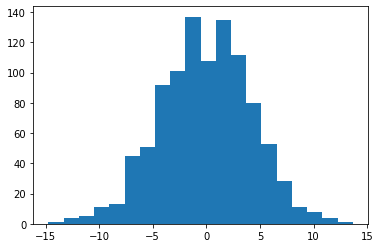

In [183]:
plt.hist(model.predict(x), bins=20)